From running CNN1 we found that the following are the best parameters: Best config: {'out_channels': 16, 'conv_kernel_size': 7, 'pool_kernel_size': 2, 'lr': 0.0005115859153484923, 'batch_size': 16}. NB: these were the results of the CNN1 model when I first ran it, then I set the seed = 42 and ran it again after having completed this model, so the aforementioned results refer to another instance. 

Since we will not fine tune them this time, we will use the aforementioned ones and will focus on a more complex architecture:

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, ConcatDataset
import os 
import random
import numpy as np
import json, re
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.optim as optim # for PyTorch optimizers
import math
import pandas as pd
from torchvision import transforms, datasets 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

SEED = 42

# Python and NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)


# Apple Silicon (MPS) - safe to call regardless of MPS availability
if hasattr(torch, "mps") and torch.backends.mps.is_available():
    torch.manual_seed(SEED)

# Deterministic behavior (may reduce speed; some ops may still be nondeterministic)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



class MediumCNN(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 7 // 2, stride =1 ), 
            nn.BatchNorm2d(16), # normalizes activations inside the net, channel after channel. Makes training quicker and more efficient. Brings mean to zero and variance to 1
            nn.ReLU(), # breaks the linearity
            nn.MaxPool2d(2), # Pool layer that returns the highest value for each 2x2 spatial region (kernel = 2 and by default stride = kernel, so number of spatial position is 4 times smaller)
            
            nn.Conv2d(in_channels= 16, out_channels = 32, kernel_size = 3, padding = 1 ), 
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
            
            ) 
        self.classifier = nn.Sequential(
            nn.LazyLinear(128), # lazy layer that outputs 128 units where you do not have to specify the number of in_features upfront.
            nn.ReLU(), 
            nn.Dropout(0.5), 
            nn.Linear(128, num_classes)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    




In [7]:
# Load datasets locally in the training function

img_size = (256, 256)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(
        brightness = 0.2,
        saturation = 0.2,
        contrast = 0.2,
        hue = 0.1,
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


train_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/train", transform=train_transform)
val_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/val", transform=train_transform)
full_ds = ConcatDataset([train_ds_local, val_ds_local])


kf = KFold(n_splits=10, shuffle=True, random_state=42)
indices = np.arange(len(full_ds))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

history = {
    "fold": [],
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

fold_summary = []  # one row per fold (e.g., best/last metrics)

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f'Fold {fold + 1}')
    train_subset = Subset(full_ds, train_idx)
    val_subset   = Subset(full_ds, val_idx)

    cnn = MediumCNN()
    cnn = cnn.to(device) # moves model parameters (weights and biases) to the target device


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.0005115859153484923, momentum = 0.9)

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size = 16,
        shuffle = True,
        num_workers = 2,
    )
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size = 16,
        shuffle = False,
        num_workers = 2,
    )

    best_val_loss = math.inf
    best_val_acc = 0.0
    

    for epoch in range(20):

        print(f'Training epoch {epoch}...')
        cnn.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        n_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(inputs)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            n_train += labels.size(0)

        train_loss = running_loss / max(n_train, 1)
        train_acc  = train_correct / max(train_total, 1)


        print(f'Loss = {round(train_loss, 4)}, Accuracy = {round(train_acc, 4)}')

        cnn.eval()
        val_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cnn(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / max(total, 1)
        val_acc = correct / max(total, 1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        history["fold"].append(fold + 1)
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f'Validation accuracy: {val_acc}')

    fold_summary.append({
    "fold": fold + 1,
    "best_val_loss": best_val_loss,
    "best_val_acc": best_val_acc,
    "last_val_loss": val_loss,
    "last_val_acc": val_acc,
        })

        

Fold 1
Training epoch 0...
Loss = 1.0568, Accuracy = 0.465
Validation accuracy: 0.6935483870967742
Training epoch 1...
Loss = 0.8137, Accuracy = 0.6272
Validation accuracy: 0.8118279569892473
Training epoch 2...
Loss = 0.702, Accuracy = 0.675
Validation accuracy: 0.8548387096774194
Training epoch 3...
Loss = 0.6482, Accuracy = 0.7068
Validation accuracy: 0.8602150537634409
Training epoch 4...
Loss = 0.5356, Accuracy = 0.772
Validation accuracy: 0.9354838709677419
Training epoch 5...
Loss = 0.4845, Accuracy = 0.7959
Validation accuracy: 0.9086021505376344
Training epoch 6...
Loss = 0.464, Accuracy = 0.8001
Validation accuracy: 0.8655913978494624
Training epoch 7...
Loss = 0.4335, Accuracy = 0.8127
Validation accuracy: 0.9247311827956989
Training epoch 8...
Loss = 0.4128, Accuracy = 0.8259
Validation accuracy: 0.9408602150537635
Training epoch 9...
Loss = 0.4326, Accuracy = 0.8223
Validation accuracy: 0.9247311827956989
Training epoch 10...
Loss = 0.3707, Accuracy = 0.842
Validation accu

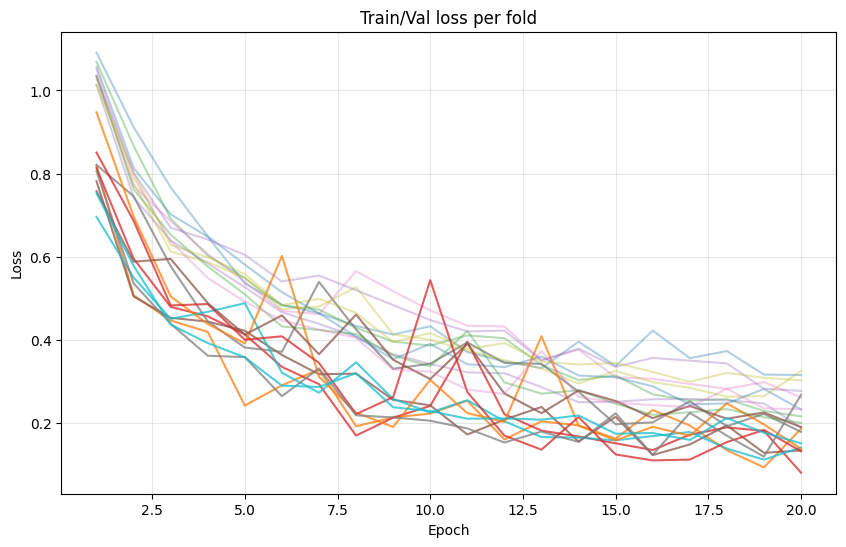

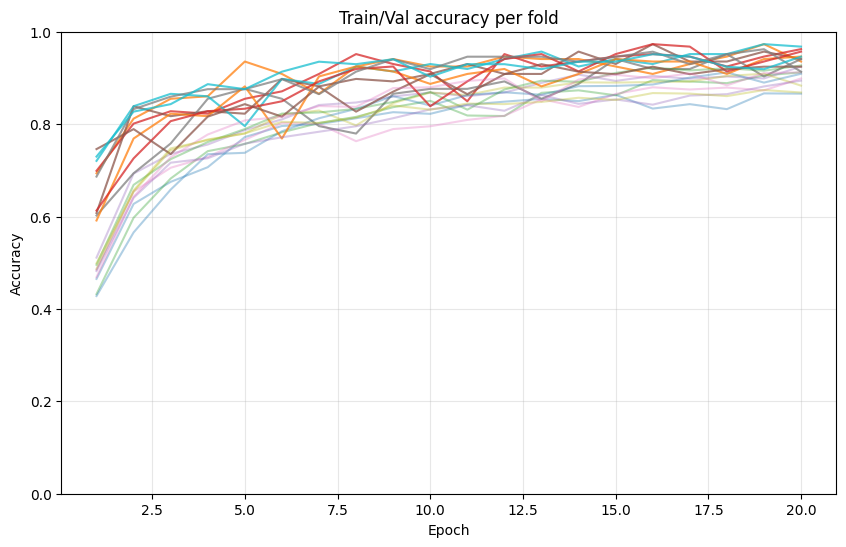

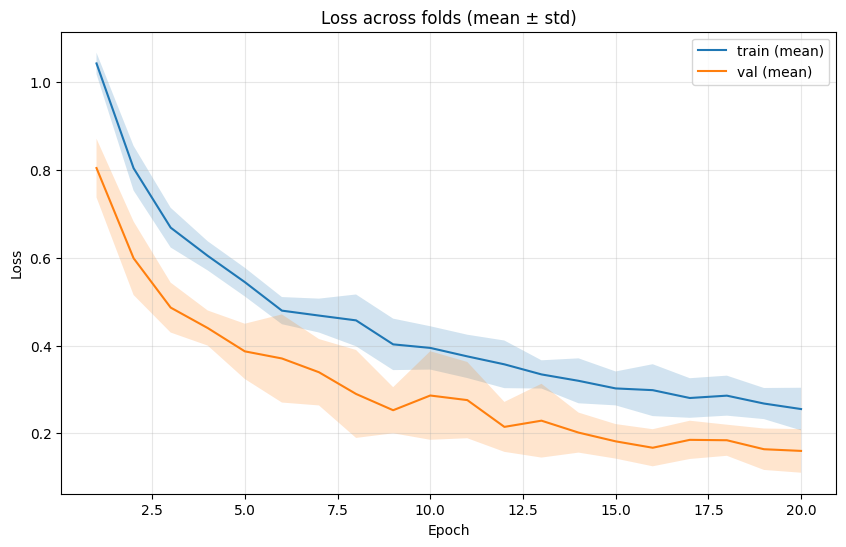

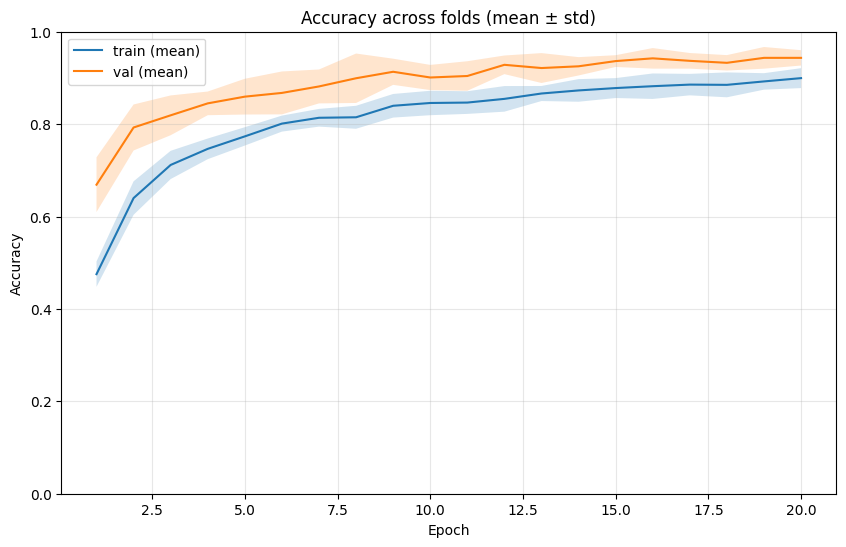

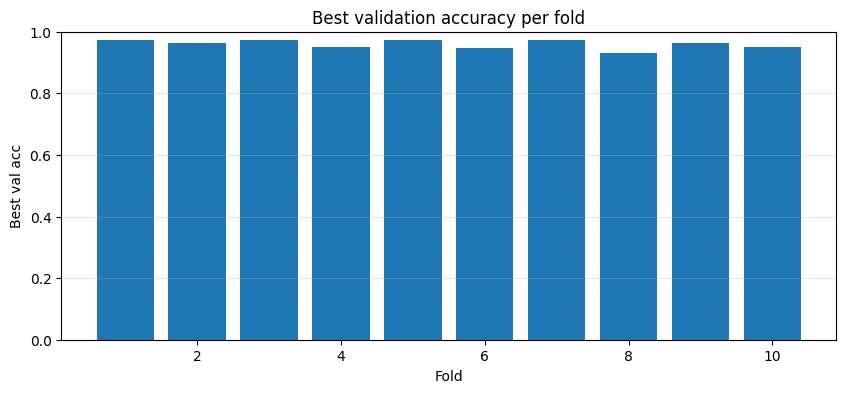

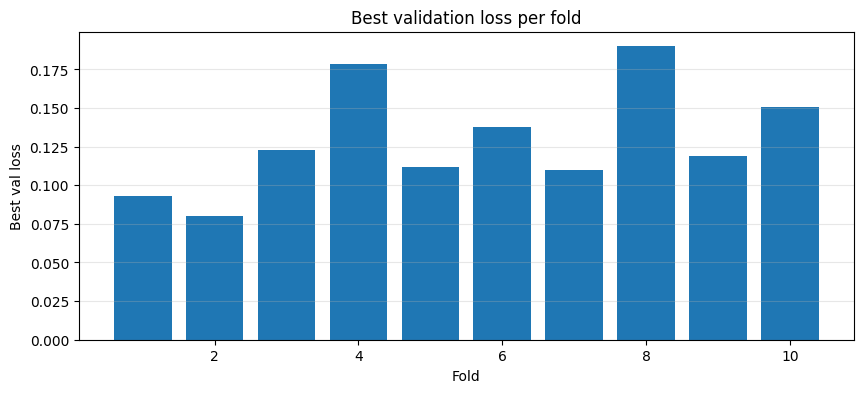

Best val acc: mean = 0.9595931415286255 std = 0.014711434507856306
Best val loss: mean = 0.12939145122620904 std = 0.0352495751410178


In [8]:

#  Convert to DataFrame
hist_df = pd.DataFrame(history)
summ_df = pd.DataFrame(fold_summary)

# Safety: ensure numeric
for c in ["fold", "epoch"]:
    hist_df[c] = hist_df[c].astype(int)

# Per-fold curves: Loss
plt.figure(figsize=(10, 6))
for fold in sorted(hist_df["fold"].unique()):
    d = hist_df[hist_df["fold"] == fold].sort_values("epoch")
    plt.plot(d["epoch"], d["train_loss"], alpha=0.35)
    plt.plot(d["epoch"], d["val_loss"],   alpha=0.75)
plt.title("Train/Val loss per fold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# Per-fold curves: Accuracy 
plt.figure(figsize=(10, 6))
for fold in sorted(hist_df["fold"].unique()):
    d = hist_df[hist_df["fold"] == fold].sort_values("epoch")
    plt.plot(d["epoch"], d["train_acc"], alpha=0.35)
    plt.plot(d["epoch"], d["val_acc"],   alpha=0.75)
plt.title("Train/Val accuracy per fold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

# Mean ± std across folds per epoch
agg = (
    hist_df
    .groupby("epoch")
    .agg(
        train_loss_mean=("train_loss", "mean"),
        train_loss_std =("train_loss", "std"),
        val_loss_mean  =("val_loss", "mean"),
        val_loss_std   =("val_loss", "std"),
        train_acc_mean =("train_acc", "mean"),
        train_acc_std  =("train_acc", "std"),
        val_acc_mean   =("val_acc", "mean"),
        val_acc_std    =("val_acc", "std"),
    )
    .reset_index()
)

# Loss mean±std
plt.figure(figsize=(10, 6))
plt.plot(agg["epoch"], agg["train_loss_mean"], label="train (mean)")
plt.fill_between(
    agg["epoch"],
    agg["train_loss_mean"] - agg["train_loss_std"].fillna(0),
    agg["train_loss_mean"] + agg["train_loss_std"].fillna(0),
    alpha=0.2
)
plt.plot(agg["epoch"], agg["val_loss_mean"], label="val (mean)")
plt.fill_between(
    agg["epoch"],
    agg["val_loss_mean"] - agg["val_loss_std"].fillna(0),
    agg["val_loss_mean"] + agg["val_loss_std"].fillna(0),
    alpha=0.2
)
plt.title("Loss across folds (mean ± std)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Accuracy mean±std
plt.figure(figsize=(10, 6))
plt.plot(agg["epoch"], agg["train_acc_mean"], label="train (mean)")
plt.fill_between(
    agg["epoch"],
    agg["train_acc_mean"] - agg["train_acc_std"].fillna(0),
    agg["train_acc_mean"] + agg["train_acc_std"].fillna(0),
    alpha=0.2
)
plt.plot(agg["epoch"], agg["val_acc_mean"], label="val (mean)")
plt.fill_between(
    agg["epoch"],
    agg["val_acc_mean"] - agg["val_acc_std"].fillna(0),
    agg["val_acc_mean"] + agg["val_acc_std"].fillna(0),
    alpha=0.2
)
plt.title("Accuracy across folds (mean ± std)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- 4) Fold-level summary plots ----
# Best val acc per fold
plt.figure(figsize=(10, 4))
plt.bar(summ_df["fold"], summ_df["best_val_acc"])
plt.title("Best validation accuracy per fold")
plt.xlabel("Fold")
plt.ylabel("Best val acc")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Best val loss per fold
plt.figure(figsize=(10, 4))
plt.bar(summ_df["fold"], summ_df["best_val_loss"])
plt.title("Best validation loss per fold")
plt.xlabel("Fold")
plt.ylabel("Best val loss")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Optional: print a numeric summary
print("Best val acc: mean =", summ_df["best_val_acc"].mean(), "std =", summ_df["best_val_acc"].std())
print("Best val loss: mean =", summ_df["best_val_loss"].mean(), "std =", summ_df["best_val_loss"].std())

Cross‑validation (CV) mainly gives you a more reliable estimate of generalization (how performance changes across different train/validation splits) and a safer way to pick things like architecture, regularization, and early‑stopping epoch without getting lucky on one particular split. Scikit‑learn even warns that training and testing on the same data is a methodological mistake and presents CV as a way to evaluate performance on unseen folds.

In [9]:

final_cnn = MediumCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_cnn.parameters(), lr=0.0005115859153484923, momentum=0.9)

final_loader = torch.utils.data.DataLoader(full_ds, batch_size=16, shuffle=True, num_workers=2)

EPOCHS_FINAL = 20  # or pick based on CV curves

for epoch in range(EPOCHS_FINAL):
    final_cnn.train()
    for inputs, labels in final_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

torch.save(final_cnn.state_dict(), "trained_cnn_final.pth")


In [16]:


TEST_DIR = "/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/test"  


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


img_size = (256, 256)
test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load test set
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_transform)
print("Test classes:", test_ds.classes, "  n_test:", len(test_ds))


cnn = MediumCNN().to(device)
cnn.load_state_dict(torch.load("trained_cnn.pth", map_location=device))
cnn.eval()


# Dataloader (you can use best batchsize or set your own)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
)

# Evaluate
criterion = nn.CrossEntropyLoss()
total, correct, test_loss_sum = 0, 0, 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = cnn(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        test_loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += bs

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

test_loss = test_loss_sum / max(total, 1)
test_acc = correct / max(total, 1)


print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test classes: ['paper', 'rock', 'scissors']   n_test: 331
Test loss: 0.1294
Test accuracy: 0.9668


Confusion matrix (counts):
 [[100   1   7]
 [  0 109   1]
 [  0   2 111]]


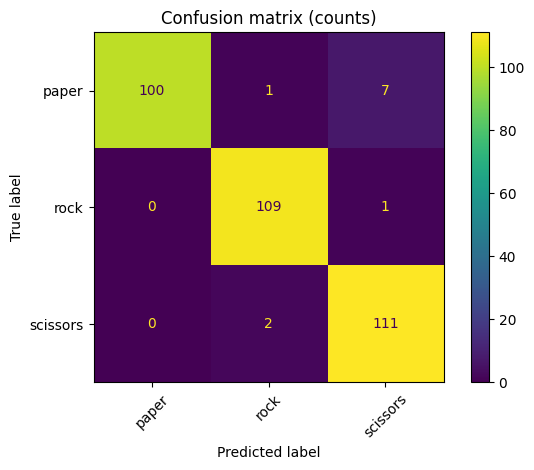

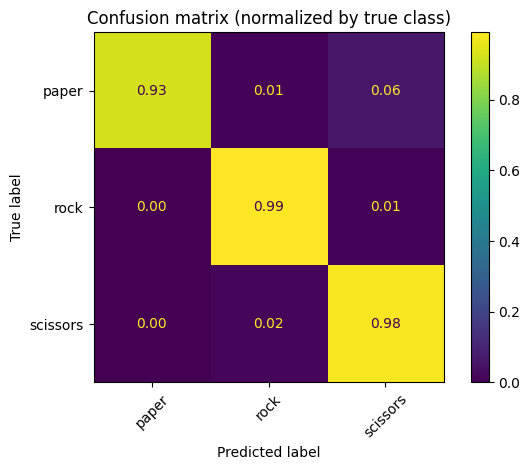


Classification report:
              precision    recall  f1-score   support

       paper     1.0000    0.9259    0.9615       108
        rock     0.9732    0.9909    0.9820       110
    scissors     0.9328    0.9823    0.9569       113

    accuracy                         0.9668       331
   macro avg     0.9687    0.9664    0.9668       331
weighted avg     0.9681    0.9668    0.9667       331



In [ ]:
# Concatenate the tensors you collected during evaluation
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred)  # C[i, j] = # true=i predicted=j [web:20]
print("Confusion matrix (counts):\n", cm)

# Optional: normalized by true class (rows sum to 1)
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")  # normalize='true' -> row-normalized [web:20]

# Plot (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix (counts)")
plt.tight_layout()
plt.show()  # ConfusionMatrixDisplay is intended for plotting a confusion matrix [web:27]

# Plot (row-normalized)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=test_ds.classes)
disp_norm.plot(xticks_rotation=45, values_format=".2f")
plt.title("Confusion matrix (normalized by true class)")
plt.tight_layout()
plt.show()  # normalize option controls how entries are normalized [web:27]

# Classification report (precision/recall/F1 per class)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))  # target_names labels classes [web:19]
